In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
import re
import os
import math


pd.set_option('display.max_columns', None)


# get games list locally instead of using the above
DF_GAMES = pd.read_csv("./scraped_data/game_data_rh.csv")
DF_EX = pd.read_csv("./scraped_data/exception_data.csv")
DF_HISTORIC = pd.read_csv("./scraped_data/historic_games_list.csv")

print(f"DF_GAMES.shape {DF_GAMES.shape}")
print(f"DF_EX.shape {DF_EX.shape}")
print(f"DF_HISTORIC.shape {DF_HISTORIC.shape}")

/var/folders/ln/sc1j8w6j0mdfbb41cy10jry00000gn/T/ipykernel_65206/249971810.py:14: DtypeWarning: Columns (15,17,24,26,33,35,42,44,51,53,60,62,69,71,78,80,87,89,96,98) have mixed types. Specify dtype option on import or set low_memory=False.
  DF_GAMES = pd.read_csv("./scraped_data/game_data_rh.csv")


DF_GAMES.shape (127274, 102)
DF_EX.shape (452, 6)
DF_HISTORIC.shape (127695, 10)


In [2]:
def clean_raw_data(df_param):
    
    # auxillary functions for conversions
    def _to_float(x): 
        try:
            return float(x)
        except:
            return -1
        
    def _assists_to_flash_assists(x):
        try:
            return int(x.split('(')[1].replace(")",""))
        except:
            return -1
    def _kast_to_float(x):
        try:
            return float(x.replace("%",""))/100
        except:
            return 0
        
    def _compute_team_rating_avg(row,teamNoStr):
        ratings = []

        try:
            ratings.append(float(row[f'{teamNoStr}_p1_game_rating']))
        except:
            pass
        try:
            ratings.append(float(row[f'{teamNoStr}_p2_game_rating']))
        except:
            pass
        try:
            ratings.append(float(row[f'{teamNoStr}_p3_game_rating']))
        except:
            pass
        try:
            ratings.append(float(row[f'{teamNoStr}_p4_game_rating']))
        except:
            pass
        try:
            ratings.append(float(row[f'{teamNoStr}_p5_game_rating']))
        except:
            pass
    
        return np.mean(ratings)

    df_param['team1'] = df_param['team1'].apply(lambda x: x.strip())
    df_param['team2'] = df_param['team2'].apply(lambda x: x.strip())
    
    df_param['team1_win'] = df_param.apply(lambda x: 1 if x['team1_rounds'] > x['team2_rounds'] else 0, axis=1) #
    df_param['team2_win'] = df_param.apply(lambda x: 1 if x['team2_rounds'] > x['team1_rounds'] else 0, axis=1) #
    
    df_param['year'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year) #target
    df_param['day'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day) #target
    df_param['month'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month) #target
    df_param['hour'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour) #target
    df_param['minute'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').minute) #target
    df_param['datetime'] = df_param['date_unix_iso'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')) 
        
    df_param['team1_rounds'] = df_param['team1_rounds'].apply(lambda x: int(x.replace("(", "" ).replace(")", "" )))
    df_param['team2_rounds'] = df_param['team2_rounds'].apply(lambda x: int(x.replace("(", "" ).replace(")", "" )))
    
    df_param['team1_rounds_clear'] = df_param['team1_rounds'] - df_param['team2_rounds']
    df_param['team2_rounds_clear'] = df_param['team2_rounds'] - df_param['team1_rounds']
    
    df_param['team1_p1_kills'] = df_param['team1_p1_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p1_kills_headshot'] = df_param['team1_p1_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team1_p1_assists_flash'] = df_param['team1_p1_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team1_p1_assists'] = df_param['team1_p1_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p1_kast'] = df_param['team1_p1_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team1_p1_adr'] = df_param['team1_p1_adr'].apply(lambda x: _to_float(x))
    df_param['team1_p1_game_rating'] = df_param['team1_p1_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team1_p2_kills'] = df_param['team1_p2_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p2_kills_headshot'] = df_param['team1_p2_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team1_p2_assists_flash'] = df_param['team1_p2_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team1_p2_assists'] = df_param['team1_p2_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p2_kast'] = df_param['team1_p2_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team1_p2_adr'] = df_param['team1_p2_adr'].apply(lambda x: _to_float(x))
    df_param['team1_p2_game_rating'] = df_param['team1_p2_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team1_p3_kills'] = df_param['team1_p3_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p3_kills_headshot'] = df_param['team1_p3_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team1_p3_assists_flash'] = df_param['team1_p3_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team1_p3_assists'] = df_param['team1_p3_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p3_kast'] = df_param['team1_p3_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team1_p3_adr'] = df_param['team1_p3_adr'].apply(lambda x: _to_float(x))
    df_param['team1_p3_game_rating'] = df_param['team1_p3_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team1_p4_kills'] = df_param['team1_p4_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p4_kills_headshot'] = df_param['team1_p4_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team1_p4_assists_flash'] = df_param['team1_p4_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team1_p4_assists'] = df_param['team1_p4_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p4_kast'] = df_param['team1_p4_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team1_p4_adr'] = df_param['team1_p4_adr'].apply(lambda x: _to_float(x))
    df_param['team1_p4_game_rating'] = df_param['team1_p4_game_rating'].apply(lambda x: _to_float(x))

    df_param['team1_p5_kills'] = df_param['team1_p5_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p5_kills_headshot'] = df_param['team1_p5_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team1_p5_assists_flash'] = df_param['team1_p5_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team1_p5_assists'] = df_param['team1_p5_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team1_p5_kast'] = df_param['team1_p5_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team1_p5_adr'] = df_param['team1_p5_adr'].apply(lambda x: _to_float(x))
    df_param['team1_p5_game_rating'] = df_param['team1_p5_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team2_p1_kills'] = df_param['team2_p1_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p1_kills_headshot'] = df_param['team2_p1_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team2_p1_assists_flash'] = df_param['team2_p1_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team2_p1_assists'] = df_param['team2_p1_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p1_kast'] = df_param['team2_p1_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team2_p1_adr'] = df_param['team2_p1_adr'].apply(lambda x: _to_float(x))
    df_param['team2_p1_game_rating'] = df_param['team2_p1_game_rating'].apply(lambda x: _to_float(x))

    df_param['team2_p2_kills'] = df_param['team2_p2_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p2_kills_headshot'] = df_param['team2_p2_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team2_p2_assists_flash'] = df_param['team2_p2_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team2_p2_assists'] = df_param['team2_p2_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p2_kast'] = df_param['team2_p2_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team2_p2_adr'] = df_param['team2_p2_adr'].apply(lambda x: _to_float(x))
    df_param['team2_p2_game_rating'] = df_param['team2_p2_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team2_p3_kills'] = df_param['team2_p3_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p3_kills_headshot'] = df_param['team2_p3_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team2_p3_assists_flash'] = df_param['team2_p3_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team2_p3_assists'] = df_param['team2_p3_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p3_kast'] = df_param['team2_p3_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team2_p3_adr'] = df_param['team2_p3_adr'].apply(lambda x: _to_float(x))
    df_param['team2_p3_game_rating'] = df_param['team2_p3_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team2_p4_kills'] = df_param['team2_p4_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p4_kills_headshot'] = df_param['team2_p4_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team2_p4_assists_flash'] = df_param['team2_p4_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team2_p4_assists'] = df_param['team2_p4_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p4_kast'] = df_param['team2_p4_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team2_p4_adr'] = df_param['team2_p4_adr'].apply(lambda x: _to_float(x))
    df_param['team2_p4_game_rating'] = df_param['team2_p4_game_rating'].apply(lambda x: _to_float(x))

    df_param['team2_p5_kills'] = df_param['team2_p5_khs'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p5_kills_headshot'] = df_param['team2_p5_khs'].apply(lambda x: int(x.split('(')[1].replace(")","")))
    df_param['team2_p5_assists_flash'] = df_param['team2_p5_assists'].apply(lambda x: _assists_to_flash_assists(x))
    df_param['team2_p5_assists'] = df_param['team2_p5_assists'].apply(lambda x: int(x.split('(')[0]))
    df_param['team2_p5_kast'] = df_param['team2_p5_kast'].apply(lambda x: _kast_to_float(x))
    df_param['team2_p5_adr'] = df_param['team2_p5_adr'].apply(lambda x: _to_float(x))
    df_param['team2_p5_game_rating'] = df_param['team2_p5_game_rating'].apply(lambda x: _to_float(x))
    
    df_param['team1_avg_adr'] = df_param.apply(lambda x: (x['team1_p1_adr'] + x['team1_p2_adr'] + x['team1_p3_adr'] + x['team1_p4_adr'] + x['team1_p5_adr'])/5, axis=1)
    df_param['team2_avg_adr'] = df_param.apply(lambda x: (x['team2_p1_adr'] + x['team2_p2_adr'] + x['team2_p3_adr'] + x['team2_p4_adr'] + x['team2_p5_adr'])/5, axis=1)
    
    df_param['team1_avg_deaths'] = df_param.apply(lambda x: (x['team1_p1_deaths'] + x['team1_p2_deaths'] + x['team1_p3_deaths'] + x['team1_p4_deaths'] + x['team1_p5_deaths'])/5, axis=1)
    df_param['team2_avg_deaths'] = df_param.apply(lambda x: (x['team2_p1_deaths'] + x['team2_p2_deaths'] + x['team2_p3_deaths'] + x['team2_p4_deaths'] + x['team2_p5_deaths'])/5, axis=1)
    
    df_param['team1_avg_kast'] = df_param.apply(lambda x: (x['team1_p1_kast'] + x['team1_p2_kast'] + x['team1_p3_kast'] + x['team1_p4_kast'] + x['team1_p5_kast'])/5, axis=1)
    df_param['team2_avg_kast'] = df_param.apply(lambda x: (x['team2_p1_kast'] + x['team2_p2_kast'] + x['team2_p3_kast'] + x['team2_p4_kast'] + x['team2_p5_kast'])/5, axis=1)
    
    df_param['team1_avg_kddiff'] = df_param.apply(lambda x: (x['team1_p1_kddiff'] + x['team1_p2_kddiff'] + x['team1_p3_kddiff'] + x['team1_p4_kddiff'] + x['team1_p5_kddiff'])/5, axis=1)
    df_param['team2_avg_kddiff'] = df_param.apply(lambda x: (x['team2_p1_kddiff'] + x['team2_p2_kddiff'] + x['team2_p3_kddiff'] + x['team2_p4_kddiff'] + x['team2_p5_kddiff'])/5, axis=1)
    
    df_param['team1_game_rating'] = df_param.apply(lambda x: _compute_team_rating_avg(x,'team1'), axis=1)
    df_param['team2_game_rating'] = df_param.apply(lambda x: _compute_team_rating_avg(x,'team2'), axis=1)
    
    df_param['team1_avg_kills'] = df_param.apply(lambda x: (x['team1_p1_kills'] + x['team1_p2_kills'] + x['team1_p3_kills'] + x['team1_p4_kills'] + x['team1_p5_kills'])/5, axis=1)
    df_param['team2_avg_kills'] = df_param.apply(lambda x: (x['team2_p1_kills'] + x['team2_p2_kills'] + x['team2_p3_kills'] + x['team2_p4_kills'] + x['team2_p5_kills'])/5, axis=1)
    
    df_param['team1_avg_kills_headshot'] = df_param.apply(lambda x: (x['team1_p1_kills_headshot'] + x['team1_p2_kills_headshot'] + x['team1_p3_kills_headshot'] + x['team1_p4_kills_headshot'] + x['team1_p5_kills_headshot'])/5, axis=1)
    df_param['team2_avg_kills_headshot'] = df_param.apply(lambda x: (x['team2_p1_kills_headshot'] + x['team2_p2_kills_headshot'] + x['team2_p3_kills_headshot'] + x['team2_p4_kills_headshot'] + x['team2_p5_kills_headshot'])/5, axis=1)
    
    df_param['team1_avg_assists'] = df_param.apply(lambda x: (x['team1_p1_assists'] + x['team1_p2_assists'] + x['team1_p3_assists'] + x['team1_p4_assists'] + x['team1_p5_assists'])/5, axis=1)
    df_param['team2_avg_assists'] = df_param.apply(lambda x: (x['team2_p1_assists'] + x['team2_p2_assists'] + x['team2_p3_assists'] + x['team2_p4_assists'] + x['team2_p5_assists'])/5, axis=1)
  
    df_param['team1_avg_assists_flash'] = df_param.apply(lambda x: (x['team1_p1_assists_flash'] + x['team1_p2_assists_flash'] + x['team1_p3_assists_flash'] + x['team1_p4_assists_flash'] + x['team1_p5_assists_flash'])/5, axis=1)
    df_param['team2_avg_assists_flash'] = df_param.apply(lambda x: (x['team2_p1_assists_flash'] + x['team2_p2_assists_flash'] + x['team2_p3_assists_flash'] + x['team2_p4_assists_flash'] + x['team2_p5_assists_flash'])/5, axis=1)
    
    
    df_param = df_param.drop(columns= ['Unnamed: 0','date_ymd', 'date_unix_iso', 'date_unix', 'game_link' ,'team1_p1_khs', 'team1_p2_khs' ,'team1_p3_khs' ,'team1_p4_khs', 'team1_p5_khs',
                                      'team2_p1_khs', 'team2_p2_khs' ,'team2_p3_khs' ,'team2_p4_khs', 'team2_p5_khs'])
    
    df_param = df_param.rename(columns={"team1_half1_t": "team1_half1", "team2_half1_ct": "team2_half1", "team1_half2_ct": "team1_half2", "team1_half2_t": "team2_half2"})
    
    df_param['target'] = df_param['team1_win'] # target
    return df_param

In [3]:
import warnings
warnings.filterwarnings("ignore") #This will ignore all DeprecationWarning warnings

df_clean = DF_HISTORIC.merge(DF_GAMES, how='inner' ,on='game_link') # merge with historic games list data
df_clean = df_clean.drop_duplicates(subset='game_link', keep="first") # drop any duplicate rows
df_clean = clean_raw_data(df_clean)

In [4]:
df = df_clean.copy()

In [5]:
# Top 10 teams ranked by games played

pd.concat([df['team1'], df['team2']]).value_counts()[0:10]

Ninjas in Pyjamas    2185
Virtus.pro           2150
fnatic               2122
MOUZ                 2026
Natus Vincere        1984
Tricked              1860
ALTERNATE aTTaX      1830
FORZE                1780
HellRaisers          1780
Liquid               1751
dtype: int64

In [6]:
# Top 10 players ranked by games played

pd.concat([df['team1_p1_name'], df['team1_p2_name'],df['team1_p3_name'], df['team1_p4_name'], df['team1_p5_name'], 
          df['team2_p1_name'], df['team2_p2_name'],df['team2_p3_name'], df['team2_p4_name'], df['team2_p5_name']]).value_counts()[0:10]

bubble    2359
TaZ       2347
Snax      2253
Lucky     2228
JW        2217
Spiidi    2200
NBK-      2194
SZPERO    2162
Furlan    2158
flusha    2155
dtype: int64

<AxesSubplot:xlabel='year', ylabel='Count'>

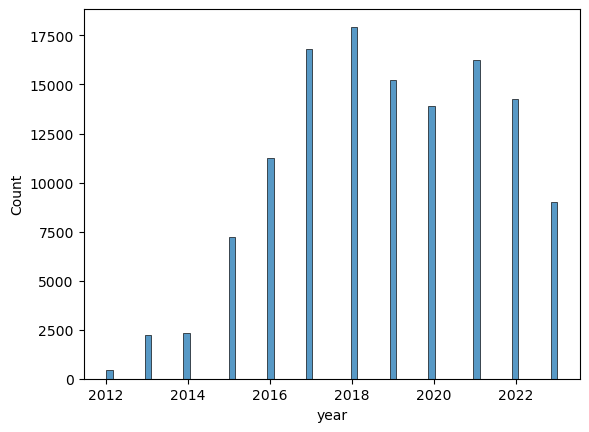

In [7]:
# games played by year
# *this data was collected September way through 2023 hence the drop in 2023

sns.histplot(data=df, x="year")

<AxesSubplot:xlabel='year', ylabel='team1_rounds_clear'>

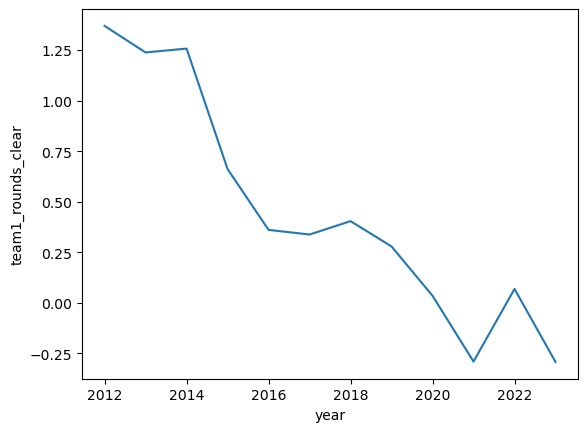

In [8]:
# CS:GO became more competetive over the years

sns.lineplot(data=df.groupby(['year'])['team1_rounds_clear'].mean())

<AxesSubplot:xlabel='year'>

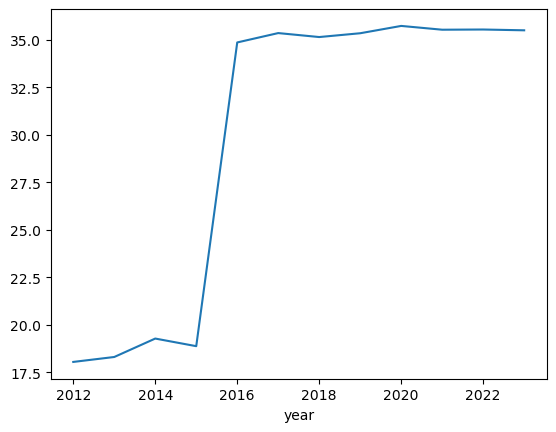

In [9]:
# Avergae kills per game has been stable since 2015
# * this data seems high to me - will do some digging into possible causes

sns.lineplot(data=df.groupby(['year'])['team1_avg_kills','team2_avg_kills'].mean().apply(lambda x: x['team1_avg_kills']+x['team2_avg_kills'], axis=1))